In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [32]:
path = '../Data/Flipkart/Images'
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [33]:
data = pd.DataFrame()
data["image_path"] = list_photos
data

,image_path
0,aa68675f50a0551b8dadb954017a50a1.jpg
1,037c2402fee39fbc80433935711d1383.jpg
2,42643c1c9403f67921a18654bcf45ead.jpg
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg
4,b144a363c107c7bdd91f32d6e28ba6f2.jpg
...,...
1045,4e5ebfc871992e7e22365c0c036a1b89.jpg
1046,82fbc93cd45ab747e7e606f2c52c7335.jpg
1047,216c6c3527984be3d7ad9023d5cd9bd1.jpg
1048,f54d0c5cbd8e2270742293edf9075cb1.jpg


In [34]:
import re
df = pd.read_csv("../Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")
df['product_category_tree'] = df['product_category_tree'].apply(lambda x: re.sub(r'>.*', '', x))
df['product_category_tree'] = df['product_category_tree'].str[2:]
df['product_category_tree'] = df['product_category_tree'].str[:-1]
df_image = []
df_image = pd.DataFrame(df_image)
df_image['image'] = df['image']
df_image['product_category_tree'] = df['product_category_tree']
print(df_image.shape)
print(data.shape)
data = pd.merge(data, df_image, left_on='image_path', right_on='image')
data = data.drop(columns=['image'])
data

(1050, 2)
(1050, 1)


,image_path,product_category_tree
0,aa68675f50a0551b8dadb954017a50a1.jpg,Kitchen & Dining
1,037c2402fee39fbc80433935711d1383.jpg,Home Furnishing
2,42643c1c9403f67921a18654bcf45ead.jpg,Baby Care
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg,Home Decor & Festive Needs
4,b144a363c107c7bdd91f32d6e28ba6f2.jpg,Watches
...,...,...
1045,4e5ebfc871992e7e22365c0c036a1b89.jpg,Baby Care
1046,82fbc93cd45ab747e7e606f2c52c7335.jpg,Home Decor & Festive Needs
1047,216c6c3527984be3d7ad9023d5cd9bd1.jpg,Home Decor & Festive Needs
1048,f54d0c5cbd8e2270742293edf9075cb1.jpg,Home Furnishing


In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data['product_category_tree'])
data['label'] = le.transform(data['product_category_tree'])
data


,image_path,product_category_tree,label
0,aa68675f50a0551b8dadb954017a50a1.jpg,Kitchen & Dining,5
1,037c2402fee39fbc80433935711d1383.jpg,Home Furnishing,4
2,42643c1c9403f67921a18654bcf45ead.jpg,Baby Care,0
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg,Home Decor & Festive Needs,3
4,b144a363c107c7bdd91f32d6e28ba6f2.jpg,Watches,6
...,...,...,...
1045,4e5ebfc871992e7e22365c0c036a1b89.jpg,Baby Care,0
1046,82fbc93cd45ab747e7e606f2c52c7335.jpg,Home Decor & Festive Needs,3
1047,216c6c3527984be3d7ad9023d5cd9bd1.jpg,Home Decor & Festive Needs,3
1048,f54d0c5cbd8e2270742293edf9075cb1.jpg,Home Furnishing,4


Home Furnishing
-------


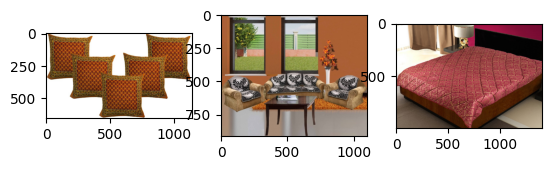

Baby Care
-------


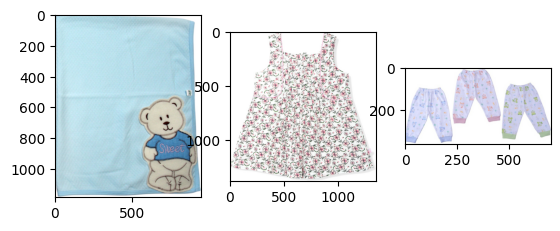

Watches
-------


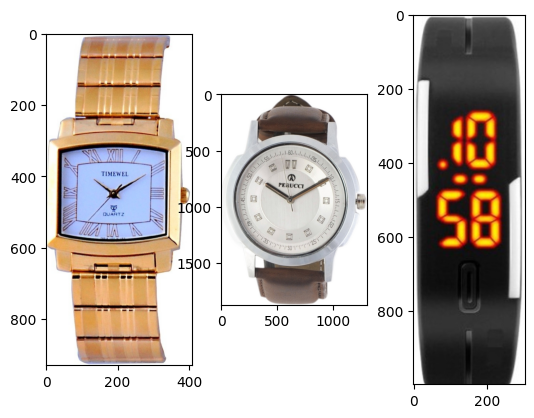

Home Decor & Festive Needs
-------


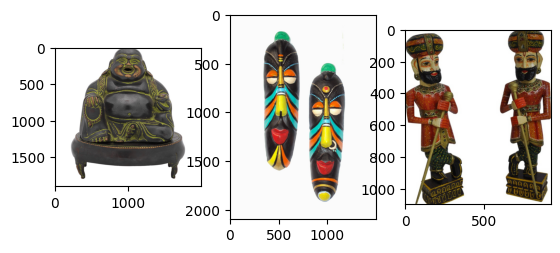

Kitchen & Dining
-------


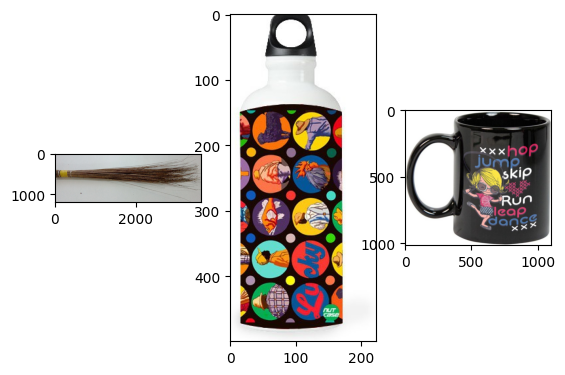

Beauty and Personal Care
-------


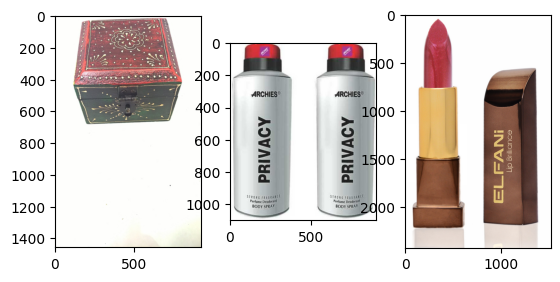

Computers
-------


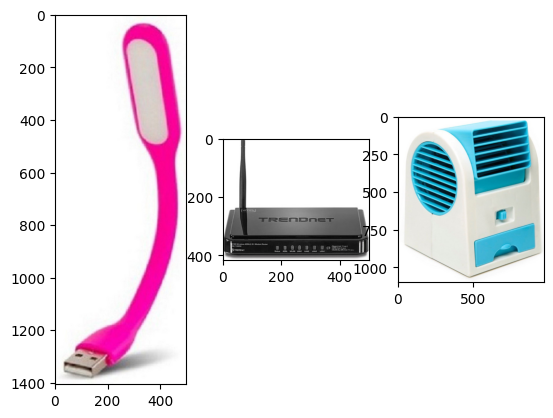

In [48]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["product_category_tree"][i]==name]
    return list_image_name




list_labels = ['Home Furnishing', 'Baby Care', 'Watches',
               'Home Decor & Festive Needs', 'Kitchen & Dining',
               'Beauty and Personal Care', 'Computers']

for name in list_labels :
    print(name)
    print("-------")
    
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i]
        image = imread(path + filename)
        plt.imshow(image)
    plt.show()

In [49]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [50]:
images_features = []
path = '../Data/Flipkart/Images/'
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1

    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200


/Applications/anaconda3/envs/Projet6Env/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


300
400
500
600
700
800
900
1000


(1050, 4096)

In [51]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [52]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             5.70 secondes


/var/folders/kl/3nc79ycx61v13jbqlw61nnfw0000gn/T/ipykernel_6319/820100085.py:5: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


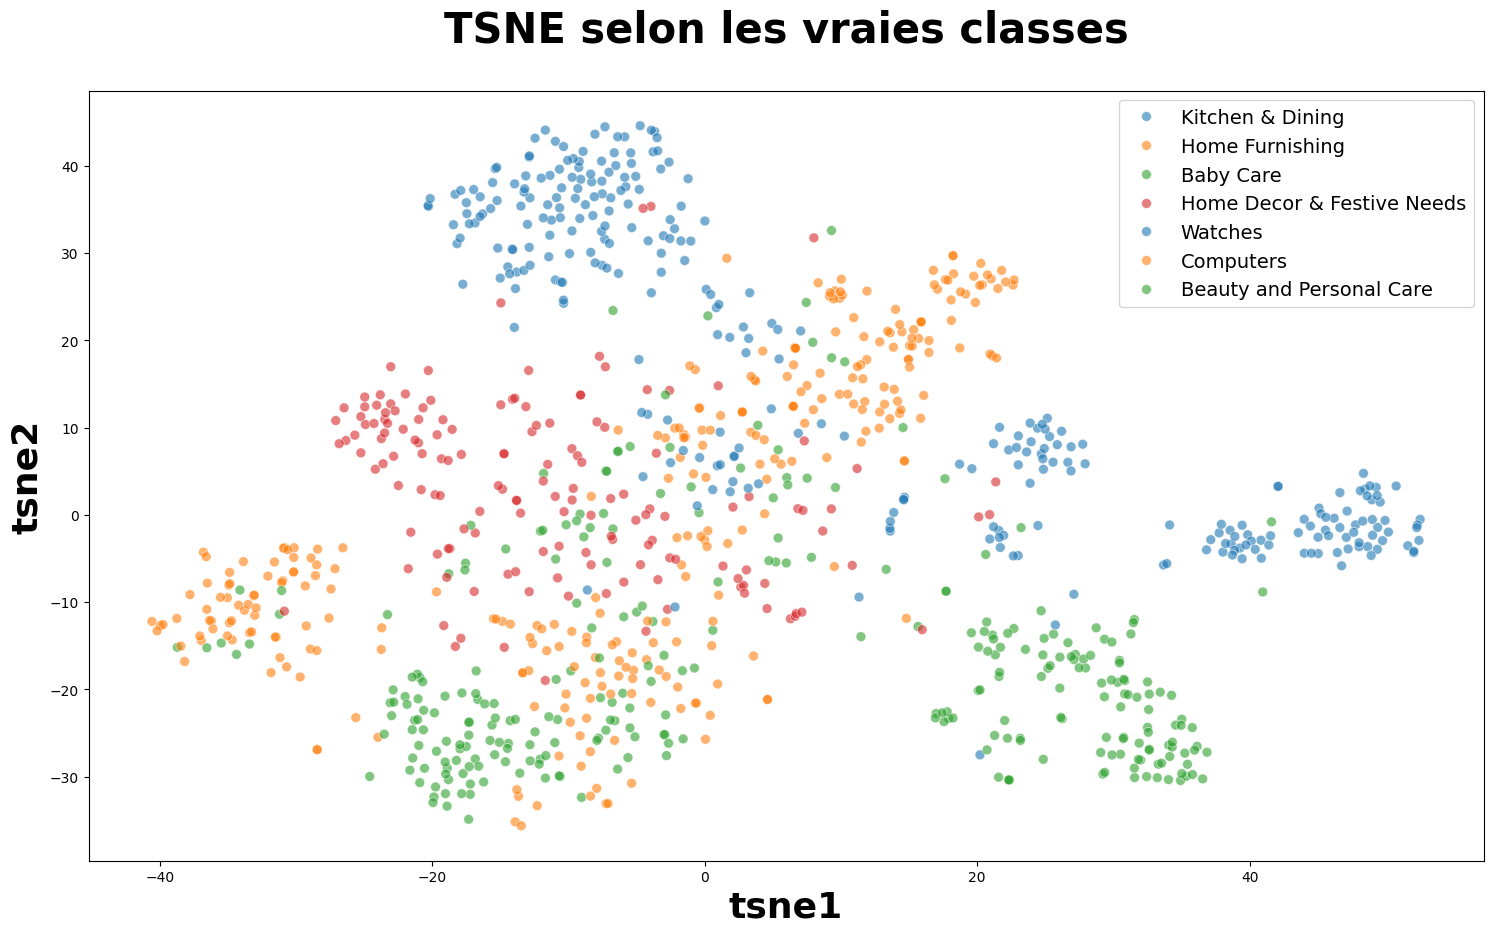

In [62]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["product_category_tree"]

plt.figure(figsize=(18,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [56]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

/var/folders/kl/3nc79ycx61v13jbqlw61nnfw0000gn/T/ipykernel_6319/2261346614.py:4: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


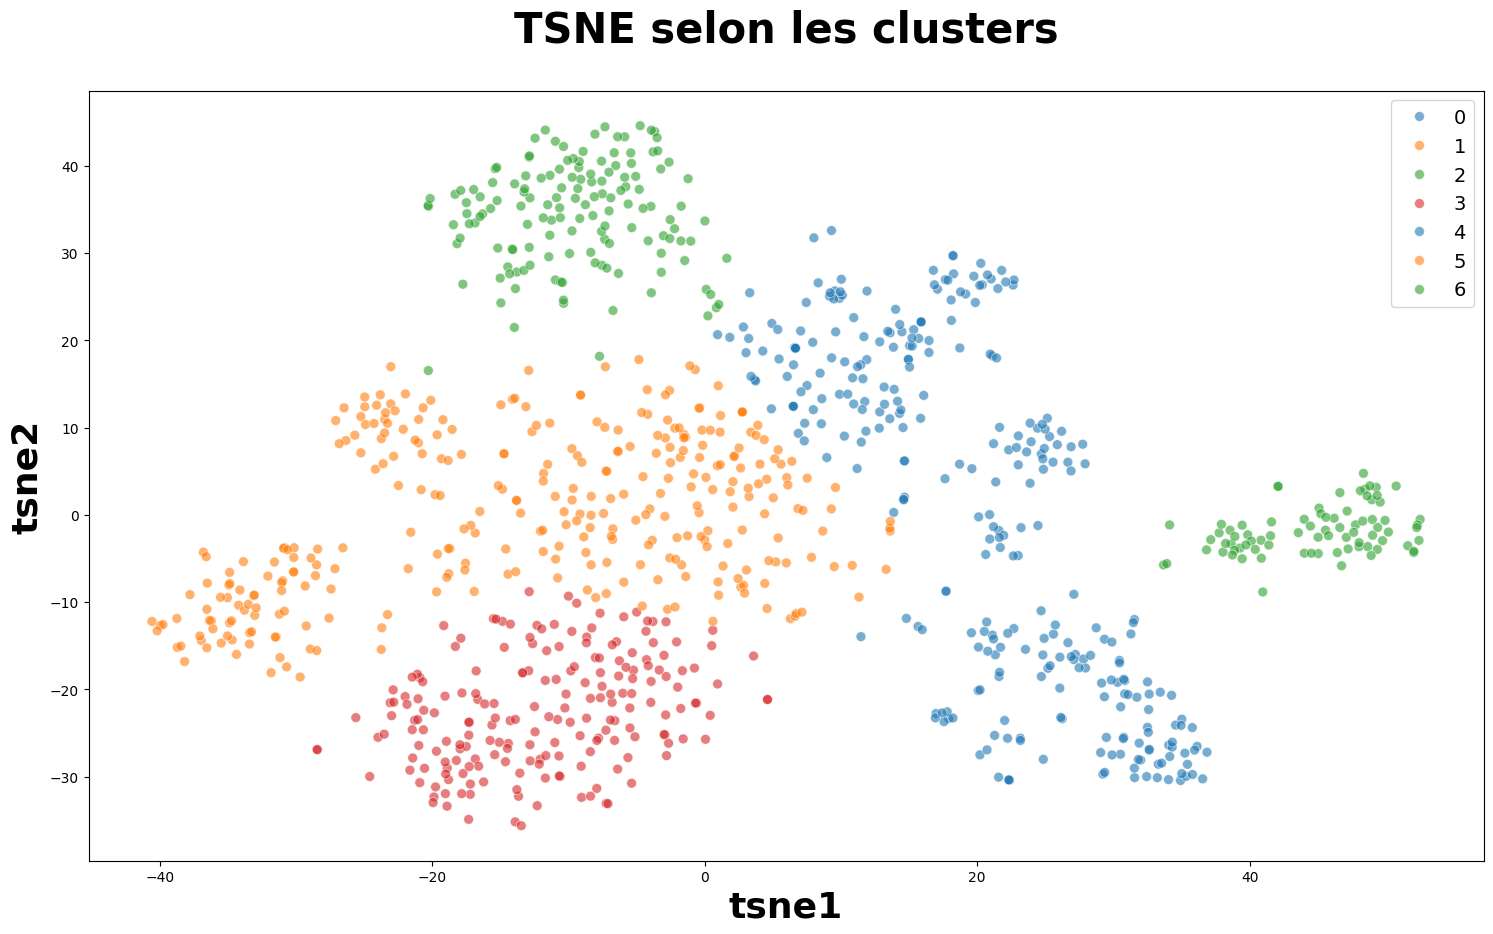

ARI :  0.44552851681659184


In [63]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(18,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))